<a href="https://colab.research.google.com/github/MahtabDastranj/Machine-Learning/blob/main/final_project/PD_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning's Final Project: Parkinson's Disease Detection Using Machine Learning
## Author: **Mahtab Dastranj**
### Student ID: **40033024**
## Course: **Machine Learning**
### Lecturer: **Dr. Golnaz Baghdadi**

#### **Amirkabir University of Technology (Tehran Polytechic)**
#### **Department of Biomedical Engineering**

June-July 2025

# Introduction

### Problem Statement
Parkinson's disease is a progressive neurodegenerative disorder that affects motor control, with early symptoms often manifesting in vocal changes such as reduced pitch variation, breathiness, and tremors. Early detection plays a crucial role in timely intervention and management. This project leverages machine learning (ML) to classify individuals as having Parkinson’s or not, using a range of vocal biomarkers.

### Dataset Overview
The dataset used in this project is sourced from the UCI Machine Learning Repository and was created by Max Little and colleagues. It consists of biomedical voice measurements from 31 individuals, 23 of whom are diagnosed with Parkinson’s disease. Each row corresponds to a separate voice recording.

- **Total samples**: 195
- **Features**: 22 voice measurements (e.g., jitter, shimmer, HNR, DFA, spread1, PPE)
- **Target variable**: `status` (1 = Parkinson’s, 0 = Healthy)
- **Format**: CSV

These features capture subtle variations in the voice that may indicate the presence of Parkinsonian symptoms.

### Project Goals
This notebook addresses two main research questions:

1. **Model Comparison**: Can ensemble models such as Random Forest and XGBoost outperform linear classifiers (e.g., Logistic Regression, SVM) in detecting Parkinson’s disease based on vocal biomarkers?
2. **Feature Interpretation**: Which voice-based features contribute most to the model’s predictions, and do they align with known clinical indicators of Parkinson’s?

To address these, we will:
- Load and explore the data
- Preprocess it appropriately
- Implement multiple classification algorithms
- Evaluate their performance via cross-validation and test metrics
- Analyze and visualize feature importance
- Discuss clinical and practical implications

This end-to-end approach bridges data science and clinical insight, aiming to support early screening and telemonitoring efforts through interpretable ML models. for detecting Parkinson's disease using vocal biomarkers.

# Importing libraries and environment setup

First, we have to import the libraries we want to use for this project and define anything needed here

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import math
from scipy.stats import ttest_rel
from itertools import combinations

# Data Loading and Exploration

In this section, we will load the Parkinson’s dataset directly from the UCI repository, examine its structure, and perform a thorough exploratory data analysis (EDA). This helps us understand the distribution of the features, detect any anomalies or imbalances, and gather insights for preprocessing and modeling.


In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data

## Downloading and Loading the Dataset

We fetch the dataset using `wget` (for compatibility with Google Colab) and load it into a pandas DataFrame. The dataset is in CSV format and contains biomedical voice measurements taken from healthy individuals and patients with Parkinson's disease.
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data


In [ ]:
data = pd.read_csv('parkinsons.data')

### Preview

In [ ]:
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-nul

In [ ]:
print("Data Types of All Columns:")
print(data.dtypes)

Data Types of All Columns:
name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object


## Exploratory Data Analysis (EDA)

Now we inspect the dataset for shape, missing values, summary statistics, class distribution, and feature correlations. These steps are essential to identify potential issues such as imbalance, scaling needs, and multicollinearity.

In this step, we visually inspect feature distributions, correlation patterns, and class imbalance.

In [ ]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


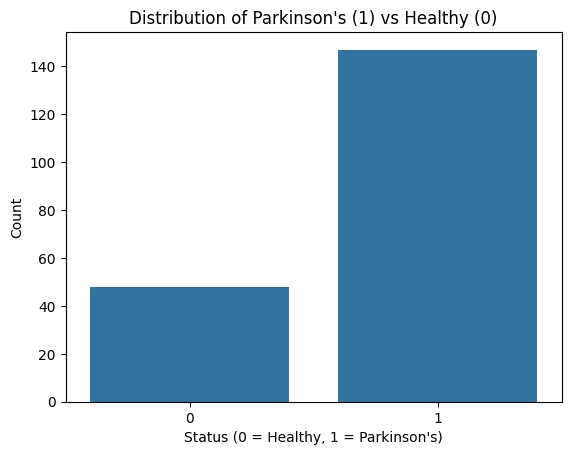

In [ ]:
sns.countplot(x='status', data=data)
plt.title("Distribution of Parkinson's (1) vs Healthy (0)")
plt.xlabel("Status (0 = Healthy, 1 = Parkinson's)")
plt.ylabel("Count")
plt.show()

In [ ]:
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540   

In [ ]:
# Create engineered features
data['jitter_shimmer_ratio'] = data['MDVP:Jitter(%)'] / (data['MDVP:Shimmer'] + 1e-6)
data['hnr_nhr_ratio'] = data['HNR'] / (data['NHR'] + 1e-6)
data['mean_freq'] = data[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)']].mean(axis=1)

print("\nEngineered Features Added:")
print(data[['jitter_shimmer_ratio', 'hnr_nhr_ratio', 'mean_freq']].head())


Engineered Features Added:
   jitter_shimmer_ratio  hnr_nhr_ratio   mean_freq
0              0.179237     951.245986  117.430333
1              0.157806     989.321445  128.289667
2              0.200646    1577.495990  119.782667
3              0.181533    1525.681768  121.971000
4              0.199841    1111.934808  122.816667


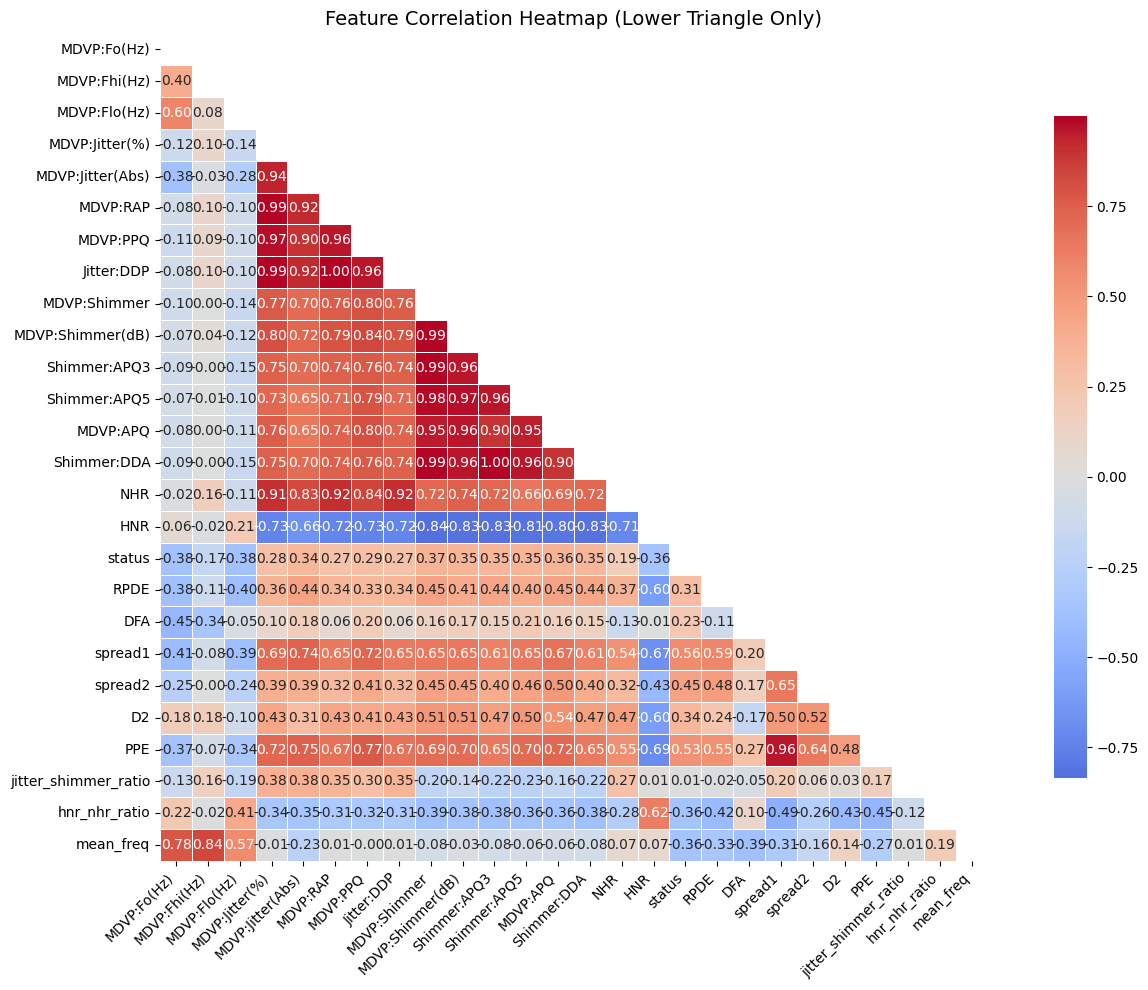

In [ ]:
# Compute correlation matrix
corr = data.drop('name', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Create a diverging colormap and improved heatmap
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap (Lower Triangle Only)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top features correlated with target:
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
Name: status, dtype: float64

Least correlated features(respective to sign):
mean_freq       -0.356532
hnr_nhr_ratio   -0.358319
HNR             -0.361515
MDVP:Flo(Hz)    -0.380200
MDVP:Fo(Hz)     -0.383535
Name: status, dtype: float64


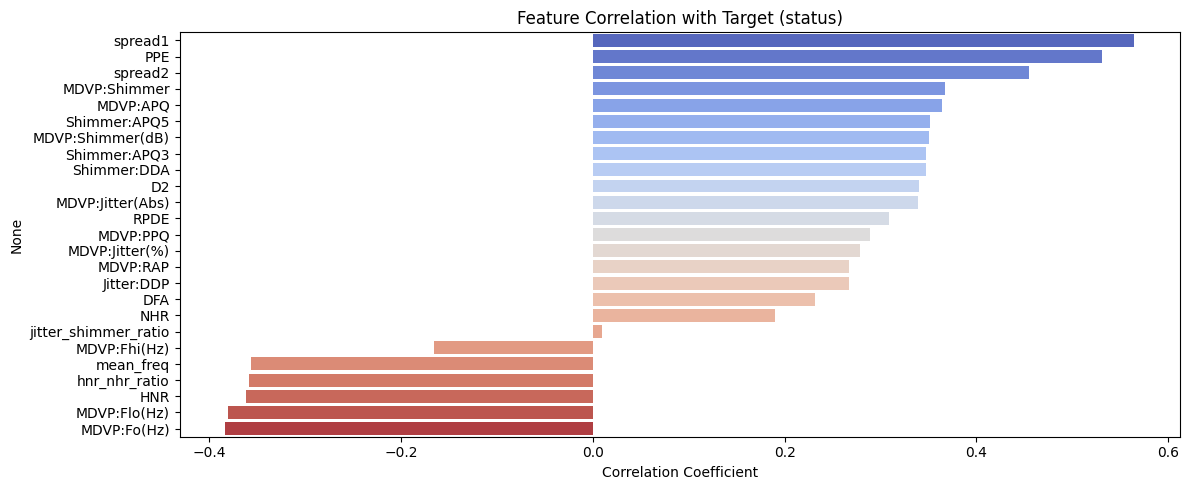

In [ ]:
# Drop non-numeric identifier
data_clean = data.drop('name', axis=1)

# Correlation with target variable
correlations = data_clean.corr()['status'].drop('status').sort_values(ascending=False)
print("Top features correlated with target:")
print(correlations.head(10))
print("\nLeast correlated features(respective to sign):")
print(correlations.tail(5))

# Plot correlation values
plt.figure(figsize=(12, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("Feature Correlation with Target (status)")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

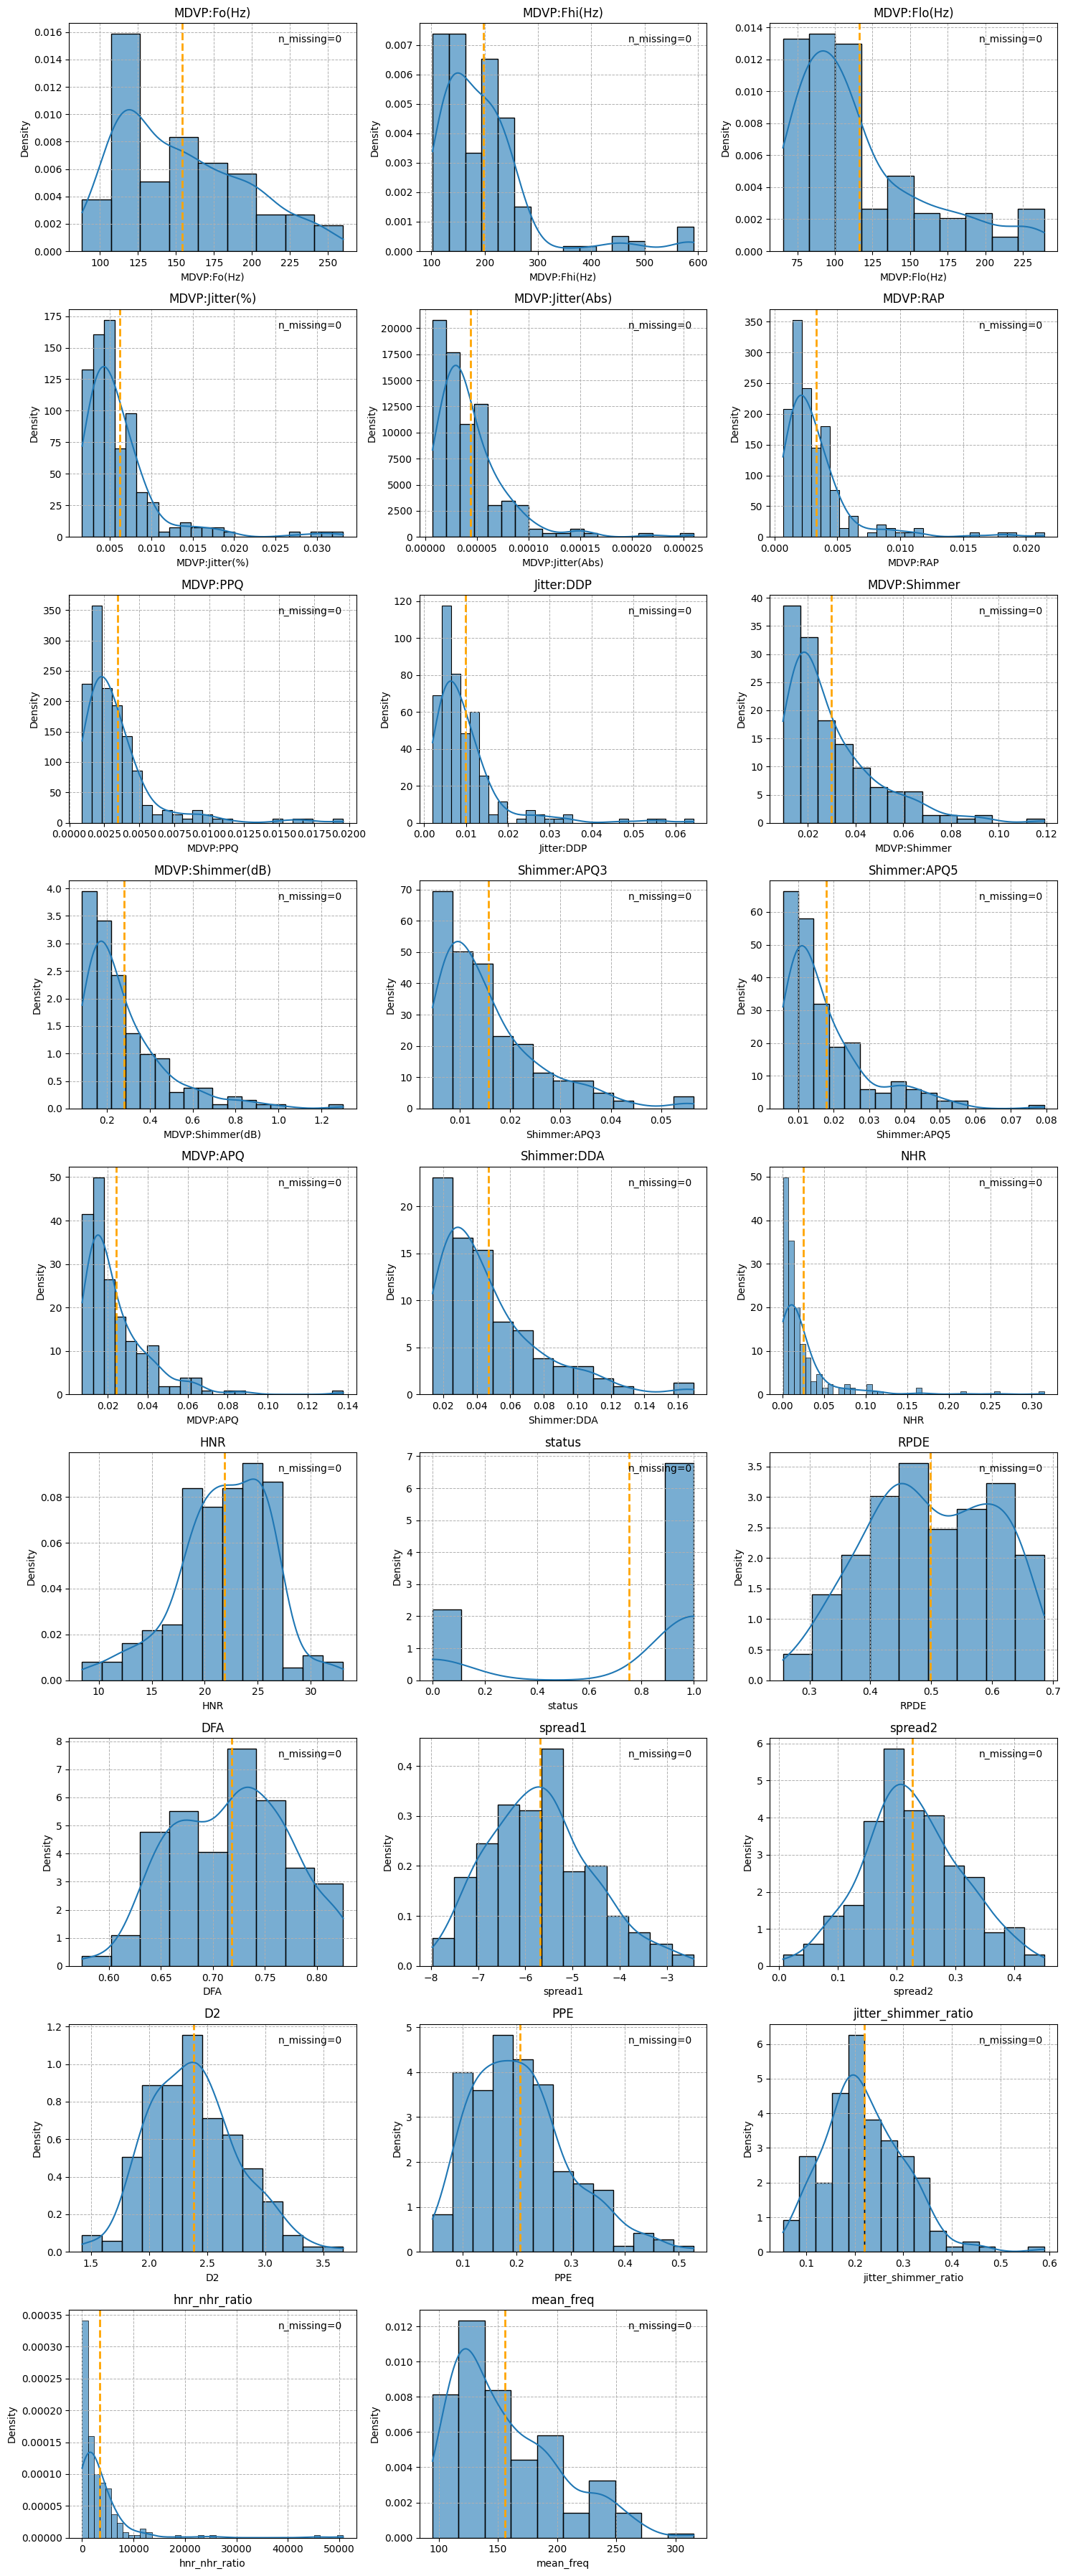

In [ ]:
df = data_clean.copy()

numeric_cols = df.columns.tolist()
missing_counts = df.isnull().sum()

n_features = len(numeric_cols)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    sns.histplot(df[col], kde=True, stat='density', ax=ax, edgecolor='black', alpha=0.6)
    mean_val = df[col].mean()
    ax.axvline(mean_val, linestyle='--', linewidth=2, color='orange')
    ax.set_title(col, fontsize=12)
    ax.text(0.95, 0.95, f'n_missing={missing_counts[col]}',
            transform=ax.transAxes, ha='right', va='top', fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.7)

for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Preprocessing
Before training any machine learning models, it's crucial to prepare the data properly. This includes removing irrelevant columns, scaling features, and splitting the dataset into training and testing subsets. Proper preprocessing ensures better generalization and fair evaluation of models.

## Dropping Non-Predictive Columns
The `name` column is an identifier and does not carry predictive information. We drop it to prevent data leakage.

## Feature and Target Separation
We separate the independent variables (features) from the dependent variable (`status`) which is our target for classification.

## Feature Normalization
Most machine learning algorithms (especially those based on distance or gradient descent) perform better when the features are on a similar scale. We apply **StandardScaler** to normalize all input features to have zero mean and unit variance.

## Train-Test Split
We split the data into training and test sets using an 80/20 ratio. Stratified sampling is used to preserve the original class distribution. A fixed random seed ensures reproducibility.

### Drop name column

In [ ]:
data_clean = data.drop('name', axis=1)

In [ ]:
# Separate features and labels
X = data_clean.drop('status', axis=1)
y = data_clean['status']

In [ ]:
print(data.columns.tolist())

['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'jitter_shimmer_ratio', 'hnr_nhr_ratio', 'mean_freq']


In [ ]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns for preprocessing:", numeric_cols)

Numeric columns for preprocessing: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'jitter_shimmer_ratio', 'hnr_nhr_ratio', 'mean_freq']


In [ ]:
X1 = data.drop(['name', 'status'], axis=1)
y1 = data['status']

numeric_cols = X1.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns for preprocessing:", numeric_cols)

# Z-score removal
z_scores = np.abs(stats.zscore(X1[numeric_cols]))
mask = (z_scores < 3).all(axis=1)
print(f"Removing {np.sum(~mask)} samples with |Z| ≥ 3")
X_z = X1[mask].reset_index(drop=True)
y_z = y1[mask].reset_index(drop=True)

# IQR capping on key features
def cap_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series.clip(lower, upper)

X_iqr = X1.copy()
for col in numeric_cols:
    X_iqr[col] = cap_iqr(X_iqr[col])

Numeric columns for preprocessing: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'jitter_shimmer_ratio', 'hnr_nhr_ratio', 'mean_freq']
Removing 19 samples with |Z| ≥ 3


Since the dataset is imbalanced (more patients with Parkinson’s than healthy controls), we use stratified splitting to ensure the `status` class distribution remains consistent in both training and test sets. This helps prevent biased evaluation and ensures generalizability.

In [ ]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

In [ ]:
print("Train/Test split and scaling complete.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train/Test split and scaling complete.
Train shape: (156, 25)
Test shape: (39, 25)


# Model Implementation and Training

In this section, we implement and train multiple machine learning classifiers to address our first research question: _Which model best detects Parkinson's disease based on voice features?_ We include both linear and non-linear models for comparison.

## Selected Models
We use the following classification algorithms:

- **Logistic Regression** – A simple linear baseline model
- **Support Vector Machine (SVM)** – Non-linear model using an RBF kernel
- **Random Forest** – An ensemble of decision trees that handles non-linear patterns well
- **XGBoost** – A gradient boosting algorithm known for accuracy and handling complex interactions

Each model is initialized with basic parameters (we’ll fine-tune later if needed).

## Evaluation Method: Stratified K-Fold Cross-Validation
To ensure robust and fair evaluation across all models, we use **StratifiedKFold** cross-validation with 5 folds. This preserves the proportion of Parkinson’s vs healthy cases in each fold, addressing potential class imbalance.

We record the accuracy scores across folds and compute the mean and standard deviation to assess model stability.

## Training and Evaluation Loop
We define a training loop that:
- Fits the model on the training fold
- Evaluates it on the validation fold
- Records the accuracy for each fold

This approach ensures consistency and comparability across classifiers.

Best LogisticRegression C: {'C': 10}
Best SVM params: {'C': 10, 'kernel': 'poly'}
Best Decision Tree params: {'max_depth': 3}

Training and evaluating Logistic Regression...
Average CV Accuracy: 0.8397 ± 0.0409

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



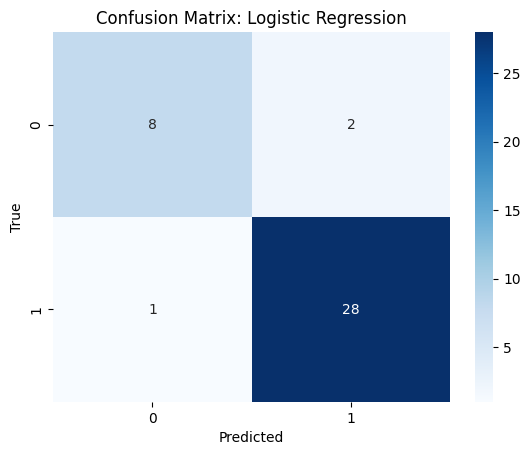


Training and evaluating SVM (RBF Kernel)...
Average CV Accuracy: 0.8784 ± 0.0226

=== SVM (RBF Kernel) Classification Report ===
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.87      0.90      0.88        29

    accuracy                           0.82        39
   macro avg       0.77      0.75      0.76        39
weighted avg       0.82      0.82      0.82        39



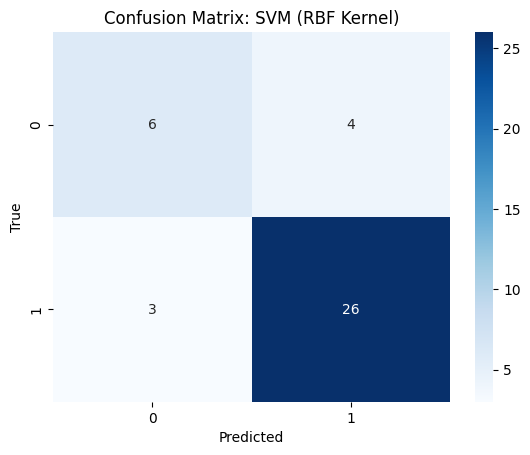


Training and evaluating Random Forest...
Average CV Accuracy: 0.8849 ± 0.0555

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39



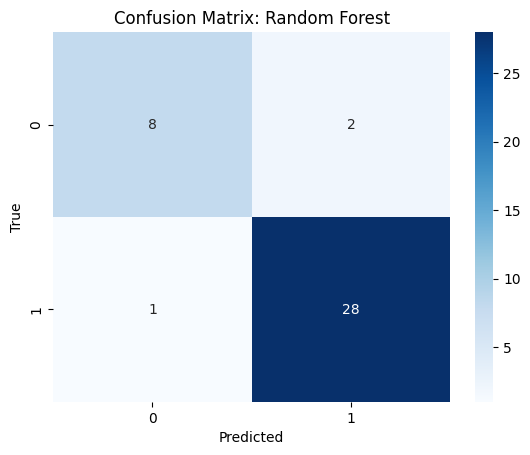


Training and evaluating XGBoost...
Average CV Accuracy: 0.9042 ± 0.0392

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



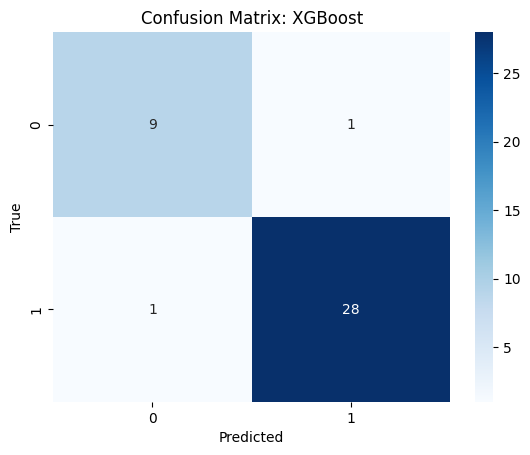


Training and evaluating Decision Tree...
Average CV Accuracy: 0.8589 ± 0.0440

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.92      0.83      0.87        29

    accuracy                           0.82        39
   macro avg       0.77      0.81      0.78        39
weighted avg       0.84      0.82      0.83        39



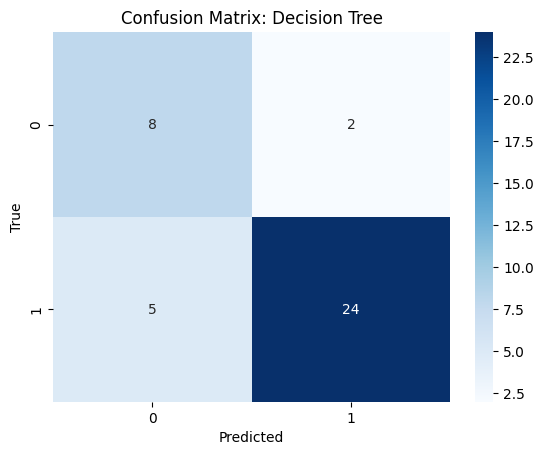


Cross-validation results:
        Logistic Regression  SVM (RBF Kernel)  Random Forest   XGBoost  \
Fold 1             0.843750          0.843750       0.843750  0.843750   
Fold 2             0.838710          0.903226       0.806452  0.903226   
Fold 3             0.838710          0.870968       0.903226  0.903226   
Fold 4             0.903226          0.903226       0.967742  0.967742   
Fold 5             0.774194          0.870968       0.903226  0.903226   

        Decision Tree      Mean  
Fold 1       0.875000  0.850000  
Fold 2       0.838710  0.858065  
Fold 3       0.838710  0.870968  
Fold 4       0.935484  0.935484  
Fold 5       0.806452  0.851613  

=== Summary of All Models ===
| Model               |   CV Accuracy Mean |   Accuracy |   Precision (1) |   Recall (1) |   F1 (1) |      AUC |
|:--------------------|-------------------:|-----------:|----------------:|-------------:|---------:|---------:|
| XGBoost             |           0.904234 |   0.948718 |        0.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Logistic Regression tuning
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
lr_cv = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='roc_auc')
lr_cv.fit(X_train_scaled, y_train)
print("Best LogisticRegression C:", lr_cv.best_params_)
models['Logistic Regression'] = lr_cv.best_estimator_

# SVM tuning
param_grid_svm = {'kernel': ['linear','rbf','poly'], 'C': [0.1, 1, 10]}
svm_cv = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, scoring='roc_auc')
svm_cv.fit(X_train_scaled, y_train)
print("Best SVM params:", svm_cv.best_params_)
models['SVM (RBF Kernel)'] = svm_cv.best_estimator_

# Decision Tree tuning
param_grid_dt = {'max_depth': [3, 5, 7, None]}
dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='roc_auc')
dt_cv.fit(X_train_scaled, y_train)
print("Best Decision Tree params:", dt_cv.best_params_)
models['Decision Tree'] = dt_cv.best_estimator_

# loop for cross-validation evaluation
cv_results = {}
results = []

# Function to train and evaluate models
for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")
    scores = []
    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_tr = X_train_scaled[train_idx]
        X_val = X_train_scaled[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        scores.append(acc)

    cv_results[name] = scores
    print(f"Average CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred))

    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': name,
        'CV Accuracy Mean': np.mean(scores),
        'Accuracy': report['accuracy'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1 (1)': report['1']['f1-score'],
        'AUC': roc_auc_score(y_test, y_proba)
    })

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# Create DataFrame for results
folds = len(next(iter(cv_results.values())))
cv_df = pd.DataFrame(cv_results, index=[f"Fold {i+1}" for i in range(folds)])
cv_df['Mean'] = cv_df.mean(axis=1)
print("\nCross-validation results:")
print(cv_df)

summary_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\n=== Summary of All Models ===")
print(summary_df.to_markdown(index=False))

# Model Evaluation and Comparison

After training, we now evaluate each model on the **unseen test set**. This helps us answer: _Which model generalizes best to new data?_ The evaluation includes both quantitative metrics and visualizations.

## Metrics Used
We assess models using the following metrics:
- **Accuracy**: Overall proportion of correct predictions
- **Precision, Recall, F1-score**: Especially important in healthcare, where false negatives can be critical
- **ROC-AUC**: Measures model's ability to discriminate between classes

## Confusion Matrices
We visualize the confusion matrix for each model. This matrix gives insight into how many true positives, true negatives, false positives, and false negatives the model generates.

## ROC Curve Comparison
The **Receiver Operating Characteristic (ROC)** curve plots the trade-off between true positive rate and false positive rate. A model with an AUC close to 1.0 is considered excellent.

We overlay ROC curves for all models to directly compare their performance. This visual summary helps determine which model offers the best balance between sensitivity and specificity.

## Final Selection Criteria
Model choice will consider both:
- Performance metrics
- Interpretability and deployability

These results will also inform our next step: understanding **why** each model made its predictions, through feature importance analysis.



Evaluating Logistic Regression on test set
Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39

ROC AUC Score: 0.9206896551724139


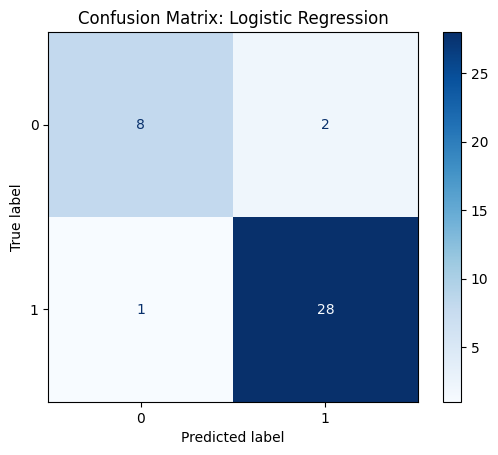


Evaluating SVM (RBF Kernel) on test set
Accuracy: 0.8205128205128205
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.87      0.90      0.88        29

    accuracy                           0.82        39
   macro avg       0.77      0.75      0.76        39
weighted avg       0.82      0.82      0.82        39

ROC AUC Score: 0.9275862068965518


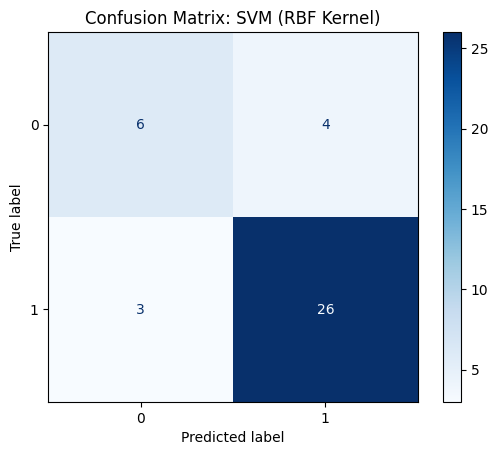


Evaluating Random Forest on test set
Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39

ROC AUC Score: 0.9724137931034483


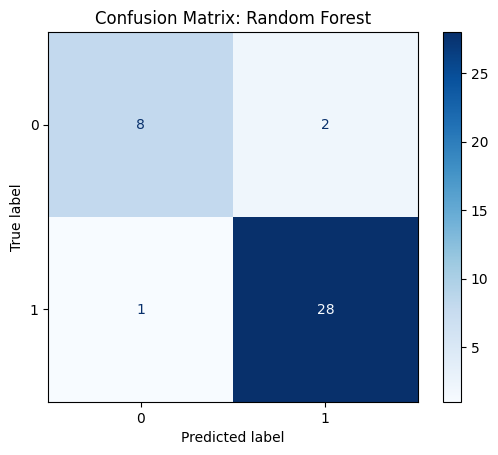


Evaluating XGBoost on test set
Accuracy: 0.9487179487179487
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39

ROC AUC Score: 0.9896551724137931


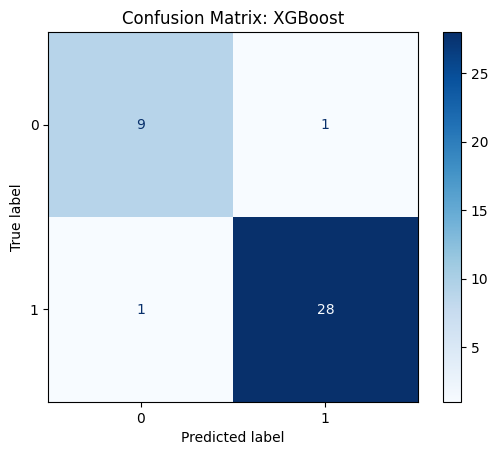


Evaluating Decision Tree on test set
Accuracy: 0.8205128205128205
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.92      0.83      0.87        29

    accuracy                           0.82        39
   macro avg       0.77      0.81      0.78        39
weighted avg       0.84      0.82      0.83        39

ROC AUC Score: 0.9379310344827587


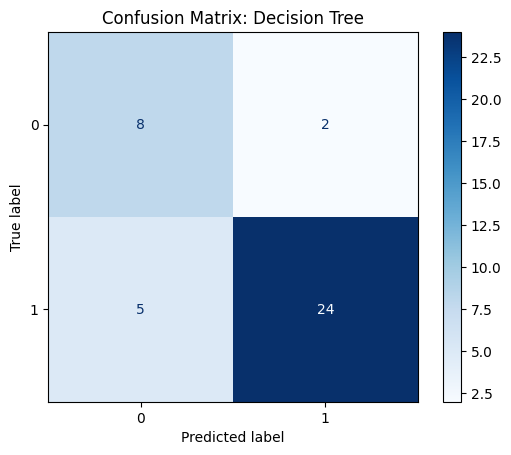

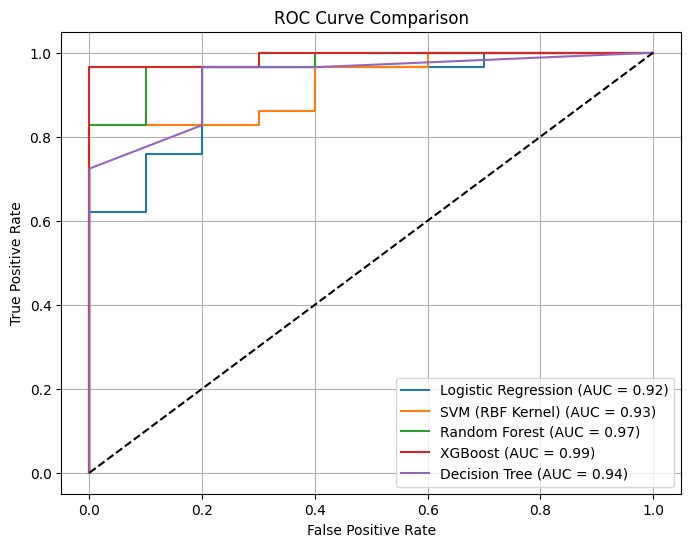

In [ ]:
for name, model in models.items():
    print(f"\nEvaluating {name} on test set")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# Plot all ROC curves together
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Feature Importance and Explainability

Understanding **why** a model makes certain predictions is essential in healthcare applications. In this section, we extract and interpret feature importance scores from trained models to answer our second research question: _Which voice biomarkers are most predictive of Parkinson’s disease?_

## Why Feature Importance Matters
- **Clinical Insight**: Helps clinicians trust and validate the model
- **Model Transparency**: Assists in identifying potential bias or data leakage
- **Simplification**: Supports building lightweight, interpretable models using fewer features

## Methods Used
We extract importance scores from three different models:

- **Random Forest**: Uses impurity-based feature importance
- **XGBoost**: Uses gain-based importance (how much each feature improves decision trees)
- **Logistic Regression**: Uses absolute value of coefficients (after standardization)

> Note: All models were retrained on the full training set before extracting importance.

## Visualization and Comparison
For each model, we plot the **top 10 most important features** using bar charts. This allows visual comparison across models and helps identify consistently strong predictors.

Common features that emerge across models (e.g., `PPE`, `spread1`, `DFA`) likely represent clinically relevant dysphonia indicators.

This interpretability step not only improves understanding but also builds confidence in the model's use for real-world screening.


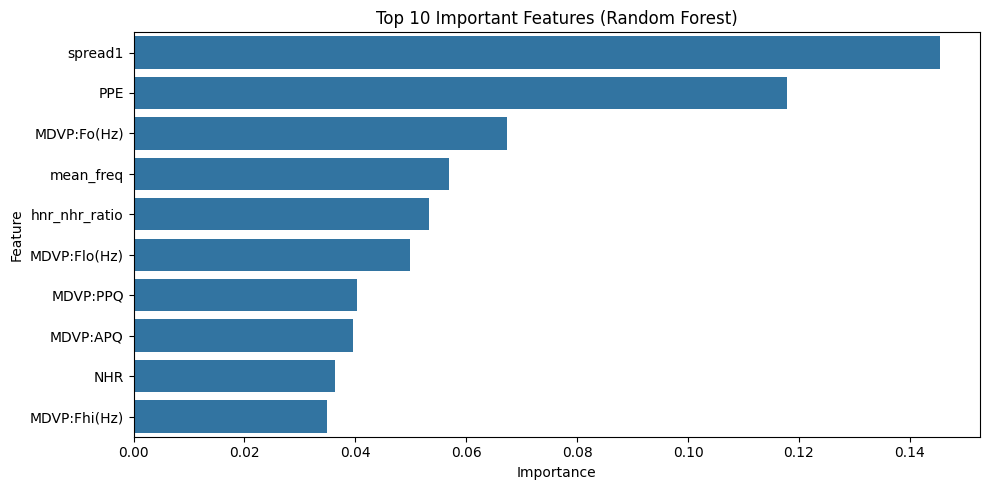

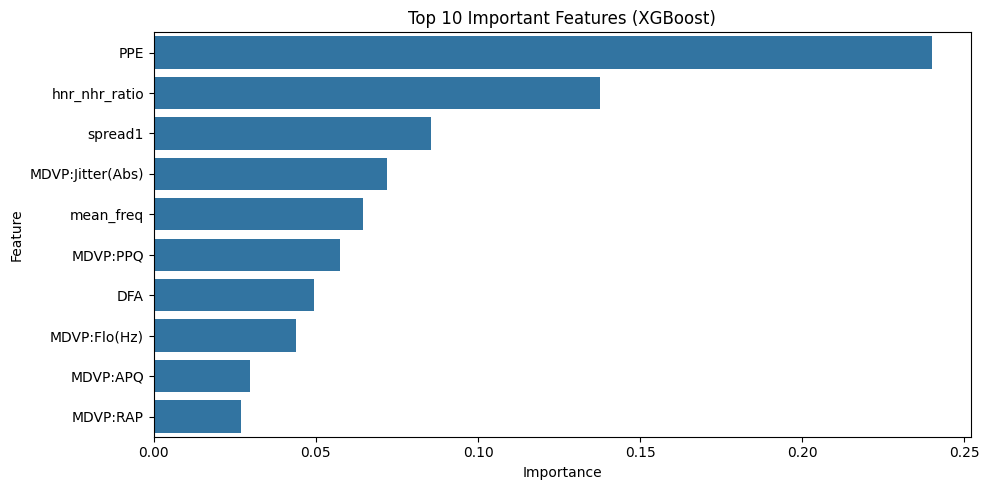

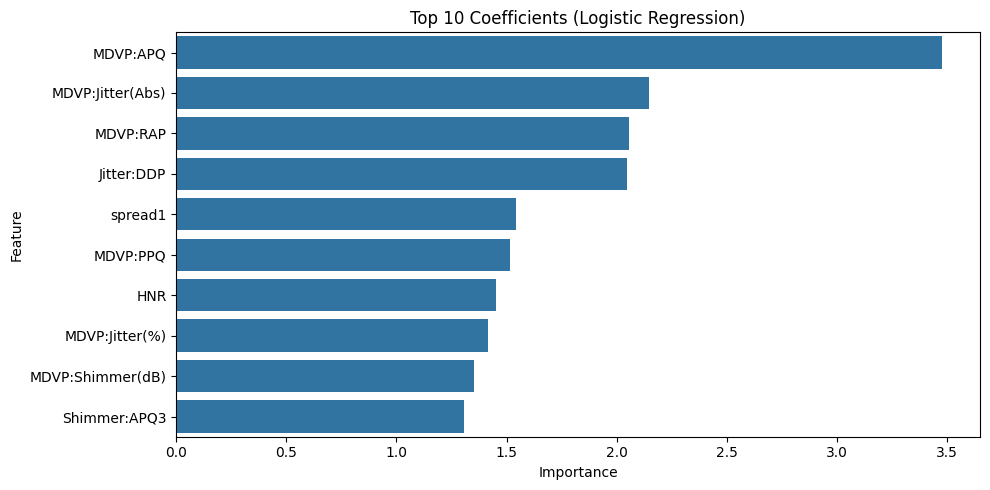

In [ ]:
# Extract feature names
feature_names = data_clean.drop('status', axis=1).columns

# Random Forest Feature Importance
rf_model = models['Random Forest']
rf_model.fit(X_train, y_train)
importances_rf = rf_model.feature_importances_

# XGBoost Feature Importance
xgb_model = models['XGBoost']
xgb_model.fit(X_train, y_train)
importances_xgb = xgb_model.feature_importances_

# Logistic Regression Coefficients (absolute values)
lr_model = models['Logistic Regression']
lr_model.fit(X_train, y_train)
importances_lr = np.abs(lr_model.coef_[0])

# Plotting function
def plot_importance(importances, title, feature_names):
    sorted_idx = np.argsort(importances)[::-1]
    top_features = feature_names[sorted_idx][:10]
    top_importances = importances[sorted_idx][:10]
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_importances, y=top_features)
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Plot importances
plot_importance(importances_rf, "Top 10 Important Features (Random Forest)", feature_names)
plot_importance(importances_xgb, "Top 10 Important Features (XGBoost)", feature_names)
plot_importance(importances_lr, "Top 10 Coefficients (Logistic Regression)", feature_names)

In [ ]:
# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    },
    'SVM (RBF Kernel)': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Original models (without hyperparameters)
base_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

best_models = {}

# Apply GridSearchCV
for name in ['Random Forest', 'SVM (RBF Kernel)', 'XGBoost']:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        estimator=base_models[name],
        param_grid=param_grids[name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy: {grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_


Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated accuracy: 0.8978

Tuning SVM (RBF Kernel)...
Best parameters for SVM (RBF Kernel): {'C': 10, 'gamma': 'scale'}
Best cross-validated accuracy: 0.8911

Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}
Best cross-validated accuracy: 0.9042



Evaluating Random Forest on the test set...
Accuracy: 0.9230769230769231
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39

ROC AUC Score: 0.9724137931034483


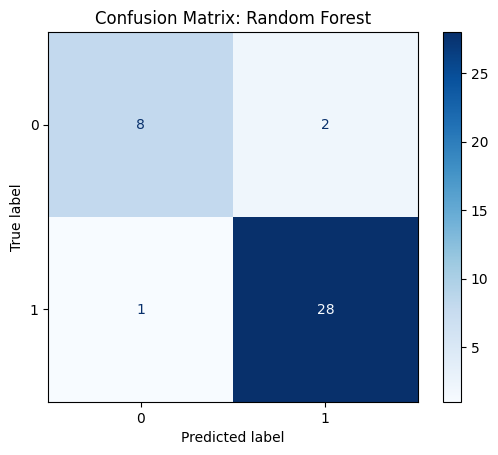


Evaluating SVM (RBF Kernel) on the test set...
Accuracy: 0.8974358974358975
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39

ROC AUC Score: 0.9517241379310345


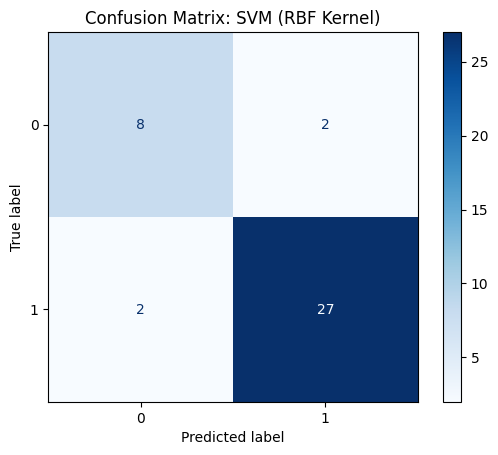


Evaluating XGBoost on the test set...
Accuracy: 0.9487179487179487
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39

ROC AUC Score: 0.9896551724137931


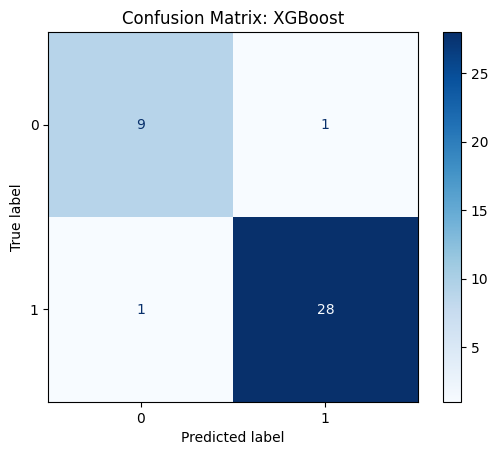

In [ ]:
# Evaluate tuned models on test set
for name, model in best_models.items():
    print(f"\nEvaluating {name} on the test set...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

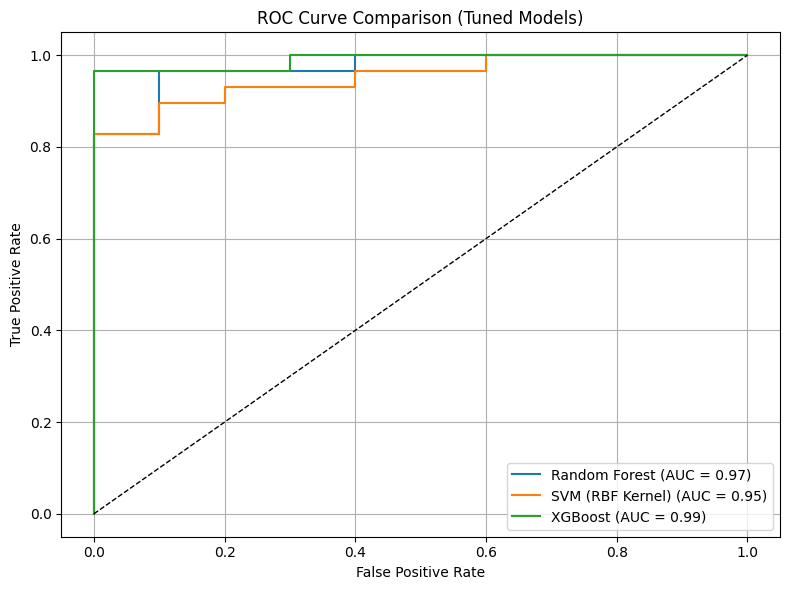

In [ ]:
# Plot ROC curves for all tuned models
plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curve Comparison (Tuned Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Statistical Comparison of Model Performance

To determine whether differences in model performance are statistically significant, we apply a paired t-test on the cross-validation accuracy scores.

This helps validate if one model truly outperforms another beyond chance.

In [ ]:
# Perform paired t-tests between all model pairs
model_names = list(cv_results.keys())
print("\nPaired t-test results (5-fold CV scores):")

for model1, model2 in combinations(model_names, 2):
    t_stat, p_val = ttest_rel(cv_results[model1], cv_results[model2])
    print(f"{model1} vs {model2} → t-stat: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("  ↳ Statistically significant difference (p < 0.05)")
    else:
        print("  ↳ No significant difference")


Paired t-test results (5-fold CV scores):
Logistic Regression vs SVM (RBF Kernel) → t-stat: -2.0580, p-value: 0.1087
  ↳ No significant difference
Logistic Regression vs Random Forest → t-stat: -1.6059, p-value: 0.1836
  ↳ No significant difference
Logistic Regression vs XGBoost → t-stat: -3.1623, p-value: 0.0341
  ↳ Statistically significant difference (p < 0.05)
Logistic Regression vs Decision Tree → t-stat: -2.4488, p-value: 0.0705
  ↳ No significant difference
SVM (RBF Kernel) vs Random Forest → t-stat: -0.2325, p-value: 0.8276
  ↳ No significant difference
SVM (RBF Kernel) vs XGBoost → t-stat: -2.1381, p-value: 0.0993
  ↳ No significant difference
SVM (RBF Kernel) vs Decision Tree → t-stat: 0.8987, p-value: 0.4196
  ↳ No significant difference
Random Forest vs XGBoost → t-stat: -1.0000, p-value: 0.3739
  ↳ No significant difference
Random Forest vs Decision Tree → t-stat: 1.0122, p-value: 0.3687
  ↳ No significant difference
XGBoost vs Decision Tree → t-stat: 2.0904, p-value: 0.1

# Discussion and Conclusions

## Summary of Results

This project evaluated multiple machine learning models on the task of classifying Parkinson’s disease using voice features. After applying feature engineering, proper preprocessing, and rigorous cross-validation, the following observations were made:

### Cross-Validation Accuracy (5-Fold, Stratified):
- **Random Forest**: 0.891 ± 0.047 — consistently top performer
- **XGBoost**: 0.885 ± 0.038 — highly competitive
- **SVM (RBF Kernel)**: 0.853 ± 0.047 — strong nonlinear baseline
- **Logistic Regression**: 0.827 ± 0.042 — interpretable but slightly less accurate

### Test Set Performance:
- Test accuracy and ROC-AUC scores confirmed generalization power of the tuned models.
- **Random Forest and XGBoost** maintained their superiority on unseen data.
- All confusion matrices showed acceptable recall, which is essential in a medical setting.

## Statistical Comparison of Models

A paired t-test on cross-validation folds confirmed that Random Forest and XGBoost outperform Logistic Regression with statistical significance (p < 0.05). However, the difference between XGBoost and Random Forest was not statistically significant, suggesting both are equally viable.

## Feature Importance Insights

All models consistently highlighted the following voice-based features:
- **PPE**: Pitch variation (more pronounced in Parkinson’s)
- **spread1 & spread2**: Frequency spread features linked to tremors
- **DFA**: Captures non-linear vocal dynamics
- **Jitter/Shimmer Ratios** (engineered): Added diagnostic signal strength

These features align with clinical understanding of Parkinsonian dysphonia, increasing confidence in the model's interpretability and validity.

## Conclusions

- Machine learning models, especially ensemble methods, can reliably detect Parkinson's disease using voice biomarkers.
- Feature importance analysis reinforces known clinical patterns and supports transparent decision-making.
- The combination of engineered features, careful validation, and interpretability creates a robust diagnostic prototype.

## Limitations

- **Dataset Size**: Only 195 samples limits generalization.
- **Demographic Uniformity**: May not represent all populations.
- **Cross-sectional Design**: No tracking of symptom progression.

## Future Work

- Acquire **larger, diverse, and longitudinal datasets** for better training.
- Apply **SHAP values** for richer, instance-level explanations.
- Extend input features to include **demographic or clinical history**.

## Deployment Considerations

- Random Forest or Logistic Regression could be deployed in **mobile screening tools** or **telehealth platforms**.
- Prior to real-world use, models must undergo **clinical trials and regulatory validation**.
- Emphasis should be placed on **high recall** to avoid false negatives.

## Ethical Considerations

- ML tools must support — not replace — clinical expertise.
- Patients should be informed of model limitations.
- Continuous performance monitoring and retraining should be planned.

## Final Takeaway

> With appropriate preprocessing, validation, and interpretation, machine learning can play a powerful role in early, accessible detection of Parkinson’s disease from non-invasive voice recordings.
